# АД-202 Щербак Максим

In [1]:
import os
import PIL
import numpy as np
import pandas as pd
import imblearn
import cv2
import keras
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Завантаження даних

In [2]:
from PIL import Image

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = Image.open(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label)
    return images, labels

def create_dataframe(train_folder, test_folder):
    train_images, train_labels = load_images_from_folder(train_folder)
    test_images, test_labels = load_images_from_folder(test_folder)
    
    images = train_images + test_images
    labels = train_labels + test_labels
    
    df = pd.DataFrame({
        'pixels': images,
        'emotion': labels
    })
    return df

train_folder = './data/train'
test_folder = './data/test'

df = create_dataframe(train_folder, test_folder)
df.head()

,pixels,emotion
0,"[[50, 32, 15, 11, 12, 10, 10, 8, 15, 10, 7, 7,...",angry
1,"[[29, 24, 29, 11, 15, 22, 26, 11, 7, 17, 29, 2...",angry
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",angry
3,"[[155, 138, 98, 112, 94, 97, 111, 107, 101, 84...",angry
4,"[[211, 215, 220, 221, 219, 216, 213, 210, 207,...",angry


In [3]:
label_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(label_names)

In [4]:
df['emotion'] = df['emotion'].str.lower()
df['emotion'] = df['emotion'].map({label_names[i]: i for i in range(num_classes)})

In [5]:
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   35887 non-null  object
 1   emotion  35887 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 560.9+ KB


# 2. Підготовка даних

## 2.1 Over-Sampling

In [6]:
data['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [7]:
from imblearn.over_sampling import RandomOverSampler

X = data.drop('emotion', axis=1)
y = data['emotion']

oversampler = RandomOverSampler(random_state=0)

X_resampled, y_resampled = oversampler.fit_resample(X, y)
data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['emotion'])], axis=1)

In [8]:
data['emotion'].value_counts()

emotion
0    8989
1    8989
2    8989
3    8989
6    8989
4    8989
5    8989
Name: count, dtype: int64

## 2.2. Нормалізація

In [9]:
image_shape = (48,48)
data['pixels'] = data['pixels'].apply(lambda x: x / 255)

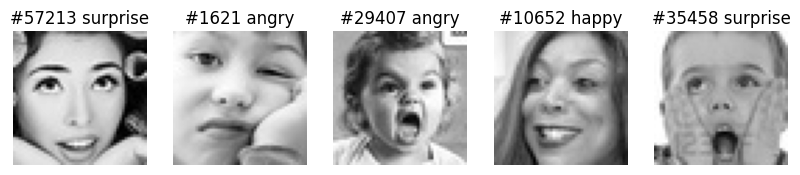

In [10]:
np.random.seed(100)

n_random_indices = 5
random_indices = np.random.choice(len(data), n_random_indices, replace=False)

fig, axes = plt.subplots(1, n_random_indices, figsize=(10, 5))

for i, idx in enumerate(random_indices):
    axes[i].imshow(data['pixels'][idx], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'#{idx+1} {label_names[data["emotion"][idx]]}')

plt.show()

## 2.4. Розділ на тренувальний, валідаційний та тестовий набори

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ohe = OneHotEncoder()
X, y = np.stack(data['pixels']), ohe.fit_transform(data['emotion'].values.reshape(-1, 1)).toarray()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [12]:
print(f"Training data length: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation data length: X {X_val.shape},Y {y_val.shape}")
print(f"Testing data length: X {X_test.shape}, Y {y_test.shape}")

Training data length: X (37753, 48, 48), Y (37753, 7)
Validation data length: X (12585, 48, 48),Y (12585, 7)
Testing data length: X (12585, 48, 48), Y (12585, 7)


In [13]:
np.unique(np.argmax(y_test, axis=1), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([1798, 1798, 1798, 1798, 1798, 1798, 1797], dtype=int64))

# 3. Побудова моделей

## 3.1. Проста модель нейронної мережі прямого поширення

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization

In [15]:
keras.utils.set_random_seed(1)

model = Sequential([
    Flatten(input_shape=X_train[0].shape),
    Dense(256, activation='relu'),  
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               590080    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                1

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
                    ])

Epoch 1/20


590/590 [==============================] - 10s 8ms/step - loss: 1.7597 - accuracy: 0.3108 - val_loss: 1.8389 - val_accuracy: 0.2905 - lr: 0.0010
Epoch 2/20
590/590 [==============================] - 4s 7ms/step - loss: 1.5646 - accuracy: 0.4001 - val_loss: 1.9425 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
590/590 [==============================] - 4s 7ms/step - loss: 1.4735 - accuracy: 0.4318 - val_loss: 1.7942 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 4/20
590/590 [==============================] - 4s 7ms/step - loss: 1.4021 - accuracy: 0.4613 - val_loss: 1.9078 - val_accuracy: 0.2861 - lr: 0.0010
Epoch 5/20
590/590 [==============================] - 5s 8ms/step - loss: 1.3468 - accuracy: 0.4760 - val_loss: 1.6751 - val_accuracy: 0.3701 - lr: 0.0010
Epoch 6/20
590/590 [==============================] - 4s 7ms/step - loss: 1.3093 - accuracy: 0.4917 - val_loss: 1.8550 - val_accuracy: 0.3153 - lr: 0.0010
Epoch 7/20
590/590 [==============================] - 4s 7ms/step -

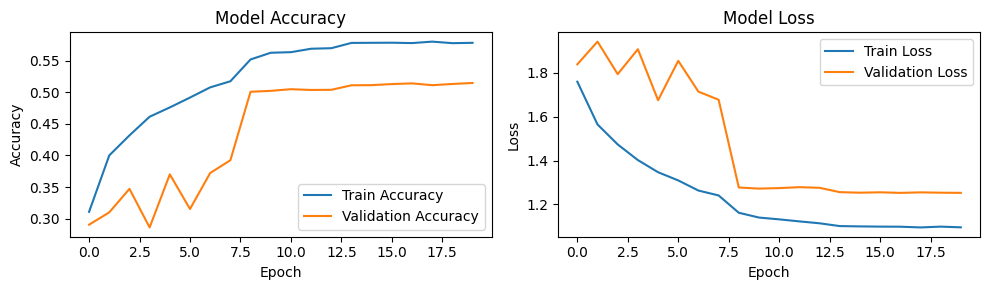

In [18]:
def plot_history(history):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_history(history)

In [19]:
score = model.evaluate(X_val, y_val)
print('val loss:', score[0])
print('val accuracy:', score[1])

394/394 [==============================] - 1s 2ms/step - loss: 1.2526 - accuracy: 0.5147
val loss: 1.2525854110717773
val accuracy: 0.5147397518157959


In [20]:
private_test_score = model.evaluate(X_test, y_test)
print('test loss:', private_test_score[0])
print('test accuracy:', private_test_score[1])

394/394 [==============================] - 1s 2ms/step - loss: 1.2479 - accuracy: 0.5177
test loss: 1.2478581666946411
test accuracy: 0.517679750919342


In [21]:
y_pred = model.predict(X_test)
predicted_labels = ohe.inverse_transform(y_pred).flatten()

394/394 [==============================] - 1s 2ms/step


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def do_classification_report(y_test, y_pred):
    y_test_inv = np.argmax(y_test, axis=1)
    y_pred_inv = np.argmax(y_pred, axis=1)
    
    precision = precision_score(y_test_inv, y_pred_inv, average='macro')
    recall = recall_score(y_test_inv, y_pred_inv, average='macro')
    f1 = f1_score(y_test_inv, y_pred_inv, average='macro')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    
    class_report = classification_report(y_test_inv, y_pred_inv)
    print('\nClassification Report:\n', class_report)

do_classification_report(y_test, y_pred)

Precision: 0.5096
Recall: 0.5177
F1-score: 0.5124

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.40      0.39      1798
           1       0.94      1.00      0.97      1798
           2       0.40      0.31      0.35      1798
           3       0.48      0.52      0.50      1798
           4       0.33      0.32      0.32      1798
           5       0.65      0.69      0.67      1798
           6       0.39      0.39      0.39      1797

    accuracy                           0.52     12585
   macro avg       0.51      0.52      0.51     12585
weighted avg       0.51      0.52      0.51     12585



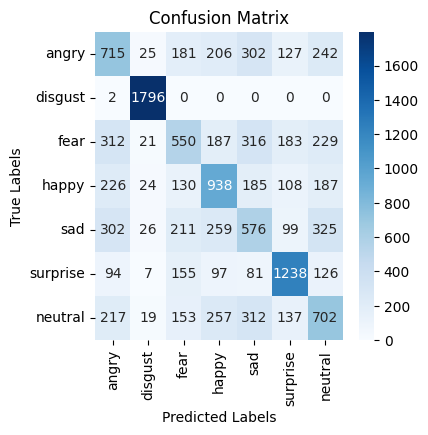

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), label_names)

In [24]:
def plot_random_images_with_histogram(X_test, y_test, y_pred, label_names, num_classes, image_shape, show_errors=False):
    np.random.seed(100)
    
    y_test_inv = np.argmax(y_test, axis=1)
    y_pred_inv = np.argmax(y_pred, axis=1)

    if show_errors:
        incorrect_indices = np.where(y_test_inv != y_pred_inv)[0]
        random_indices = np.random.choice(incorrect_indices, size=3, replace=False)
    else:
        correct_indices = np.where(y_test_inv == y_pred_inv)[0]
        random_indices = np.random.choice(correct_indices, size=3, replace=False)

    fig, axes = plt.subplots(3, 2, figsize=(12, 6))

    for i, idx in enumerate(random_indices):
        axes[i, 0].imshow(X_test[idx], cmap='gray')
        axes[i, 0].set_title(f'True Label: {label_names[y_test_inv[idx]]}')
        axes[i, 0].axis('off')

        bar_colors = ['skyblue'] * num_classes
        bar_colors[y_pred_inv[idx]] = 'salmon'
        axes[i, 1].bar(np.arange(num_classes), y_pred[idx], color=bar_colors)
        axes[i, 1].set_title(f'Predicted Label: {label_names[y_pred_inv[idx]]}')
        axes[i, 1].set_xlabel('Class')
        axes[i, 1].set_ylabel('Probability')
        axes[i, 1].set_xticks(np.arange(num_classes))
        axes[i, 1].set_xticklabels(label_names, rotation=0)
        axes[i, 1].set_ylim([0, 1]) 

    plt.tight_layout()
    plt.show()

def plot_correct_image_labels(X_test, y_test, y_pred, label_names, num_classes, image_shape):
    plot_random_images_with_histogram(X_test, y_test, y_pred, label_names, num_classes, image_shape)

def plot_wrong_image_labels(X_test, y_test, y_pred, label_names, num_classes, image_shape):
    plot_random_images_with_histogram(X_test, y_test, y_pred, label_names, num_classes, image_shape, True)

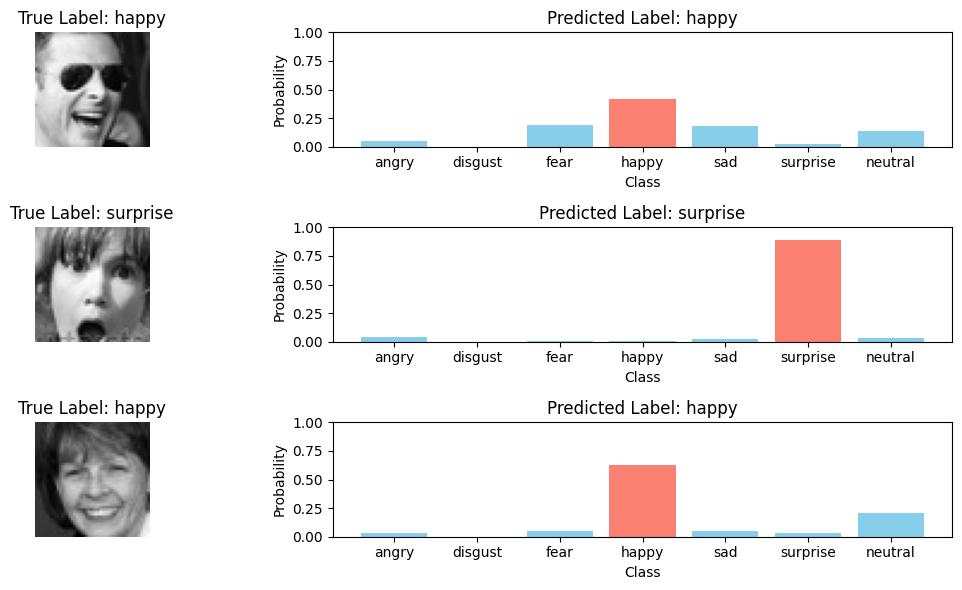

In [25]:
plot_correct_image_labels(X_test, y_test, y_pred, label_names, num_classes, image_shape)

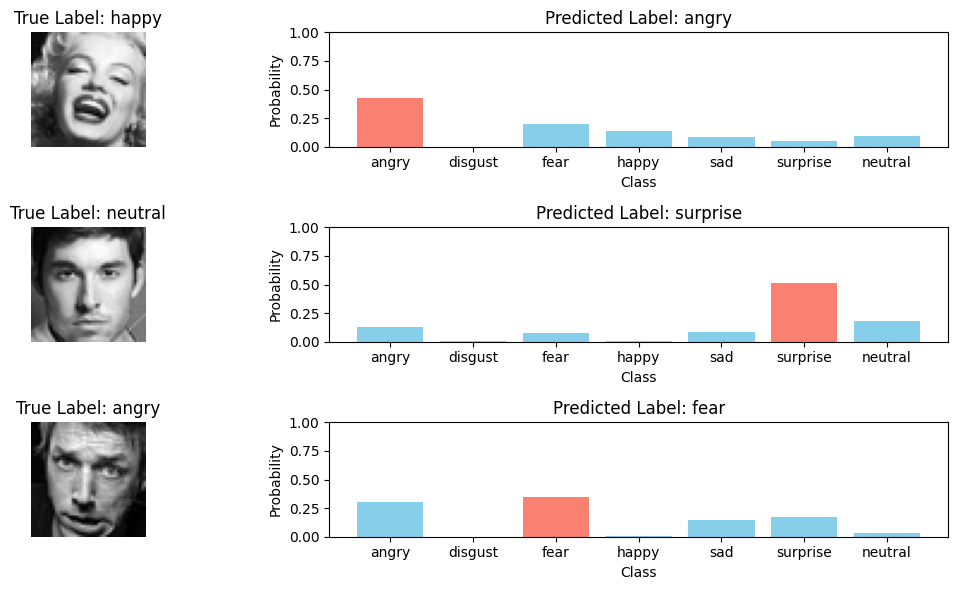

In [26]:
plot_random_images_with_histogram(X_test, y_test, y_pred, label_names, num_classes, image_shape, True)

In [27]:
model.save('model_dense.keras')

## 3.2. Модель згорткової нейронної мережі

In [28]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape

In [29]:
keras.utils.set_random_seed(1)

model = Sequential([
    Reshape(image_shape + (1,), input_shape=image_shape),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu',),
    BatchNormalization(),
    Dense(32, activation='relu',),   
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)         

In [31]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
                    ])

Epoch 1/30
590/590 [==============================] - 16s 25ms/step - loss: 1.6959 - accuracy: 0.3353 - val_loss: 1.6256 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 14s 24ms/step - loss: 1.4287 - accuracy: 0.4564 - val_loss: 1.4965 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 14s 24ms/step - loss: 1.3026 - accuracy: 0.5048 - val_loss: 1.4841 - val_accuracy: 0.4334 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 14s 24ms/step - loss: 1.2289 - accuracy: 0.5329 - val_loss: 1.3360 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 14s 24ms/step - loss: 1.1690 - accuracy: 0.5518 - val_loss: 1.3367 - val_accuracy: 0.4885 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 14s 24ms/step - loss: 1.1256 - accuracy: 0.5721 - val_loss: 2.2041 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 14s 

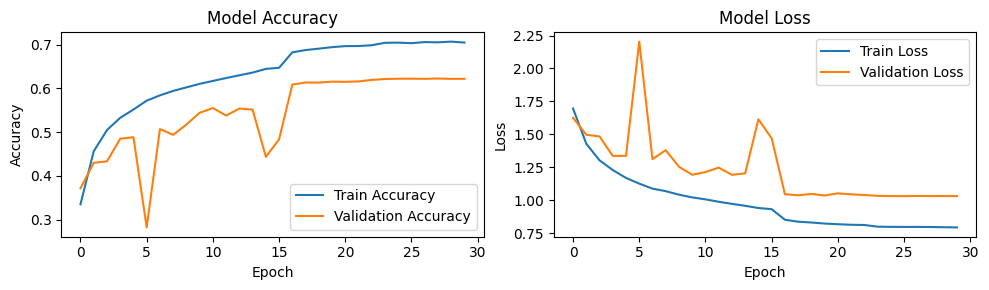

In [32]:
plot_history(history)

In [33]:
score = model.evaluate(X_val, y_val)
print('val loss:', score[0])
print('val accuracy:', score[1])

394/394 [==============================] - 2s 5ms/step - loss: 1.0307 - accuracy: 0.6220
val loss: 1.0307321548461914
val accuracy: 0.622010350227356


In [34]:
score = model.evaluate(X_test, y_test)
print('test loss:', score[0])
print('test accuracy:', score[1])

394/394 [==============================] - 2s 5ms/step - loss: 1.0361 - accuracy: 0.6230
test loss: 1.0360808372497559
test accuracy: 0.6230432987213135


In [35]:
y_pred = model.predict(X_test)
predicted_labels = ohe.inverse_transform(y_pred).flatten()

394/394 [==============================] - 2s 5ms/step


In [36]:
do_classification_report(y_test, y_pred)

Precision: 0.6176
Recall: 0.6230
F1-score: 0.6192

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.55      0.53      1798
           1       0.94      1.00      0.97      1798
           2       0.48      0.39      0.43      1798
           3       0.70      0.67      0.68      1798
           4       0.42      0.42      0.42      1798
           5       0.76      0.81      0.79      1798
           6       0.50      0.52      0.51      1797

    accuracy                           0.62     12585
   macro avg       0.62      0.62      0.62     12585
weighted avg       0.62      0.62      0.62     12585



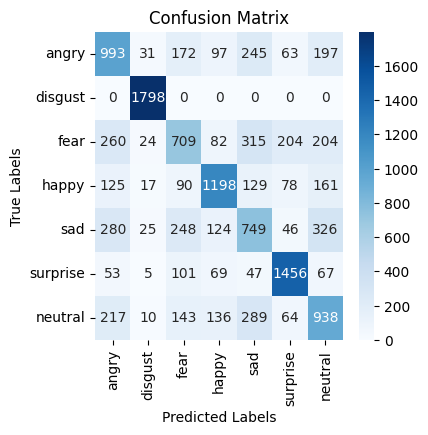

In [37]:
plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), label_names)

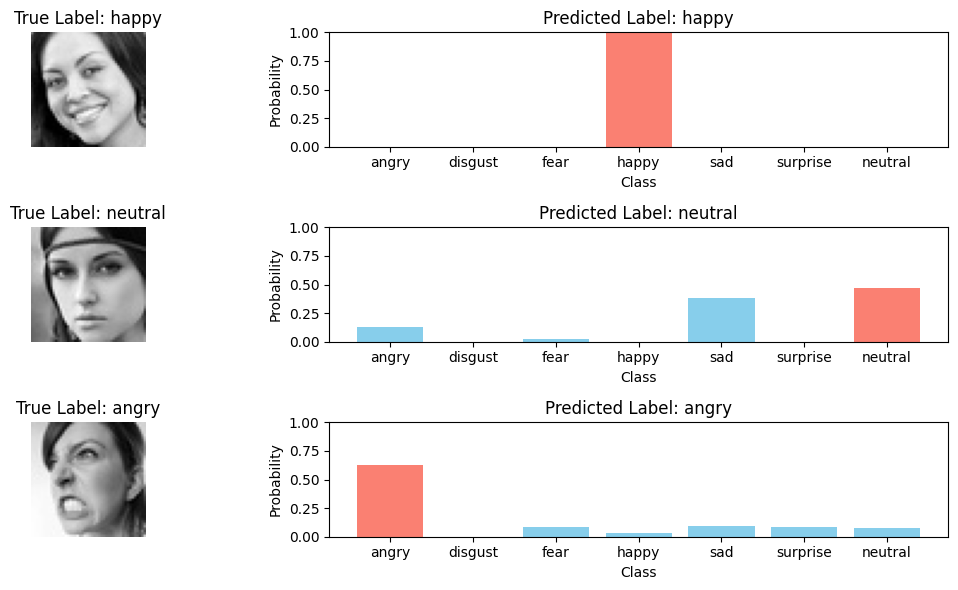

In [38]:
plot_correct_image_labels(X_test, y_test, y_pred, label_names, num_classes, image_shape)

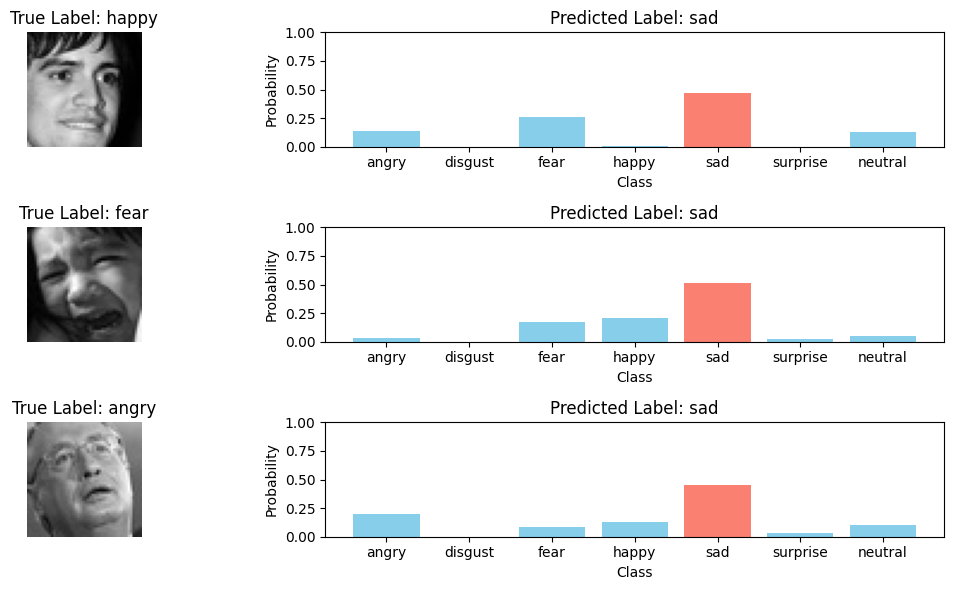

In [39]:
plot_wrong_image_labels(X_test, y_test, y_pred, label_names, num_classes, image_shape)

In [40]:
model.save('model_convolutional.keras')

## 3.2 Нейронна мережа на основі MobileNetV2

In [41]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Input, Reshape
from keras.preprocessing.image import ImageDataGenerator

In [42]:
keras.utils.set_random_seed(1)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_7 (Dense)             (None, 128)               163968    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2430663 (9.27 MB)
Trainable params: 1726

In [43]:
def reshape_and_resize_generator(X, new_size=(224, 224)):
    for i in range(X.shape[0]):
        image = np.expand_dims(X[i], axis=-1)
        image = np.repeat(image, 3, axis=-1)
        resized_image = cv2.resize(image, new_size)
        yield resized_image

def batch_generator(X, y, batch_size, new_size=(224, 224)):
    while True:
        for start in range(0, X.shape[0], batch_size):
            end = min(start + batch_size, X.shape[0])
            batch_X = X[start:end]
            batch_y = y[start:end]
            resized_batch_X = np.array([img for img in reshape_and_resize_generator(batch_X, new_size)])
            yield resized_batch_X, batch_y

batch_size = 128
train_generator = batch_generator(X_train, y_train, batch_size)
val_generator = batch_generator(X_val, y_val, batch_size)
test_generator = batch_generator(X_test, y_test, batch_size)

In [44]:
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=val_generator,
                    validation_steps=len(X_val) // batch_size,
                    epochs=30,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
                    ])

Epoch 1/30
294/294 [==============================] - 428s 1s/step - loss: 1.5062 - accuracy: 0.4298 - val_loss: 1.3539 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 2/30
294/294 [==============================] - 429s 1s/step - loss: 1.2383 - accuracy: 0.5394 - val_loss: 1.2228 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 3/30
294/294 [==============================] - 426s 1s/step - loss: 1.1113 - accuracy: 0.5834 - val_loss: 1.1467 - val_accuracy: 0.5674 - lr: 0.0010
Epoch 4/30
294/294 [==============================] - 429s 1s/step - loss: 1.0322 - accuracy: 0.6132 - val_loss: 1.1043 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 5/30
294/294 [==============================] - 419s 1s/step - loss: 0.9707 - accuracy: 0.6364 - val_loss: 1.1243 - val_accuracy: 0.5801 - lr: 0.0010
Epoch 6/30
294/294 [==============================] - 410s 1s/step - loss: 0.9116 - accuracy: 0.6612 - val_loss: 1.0717 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 7/30
294/294 [==============================] - 394s 1s/st

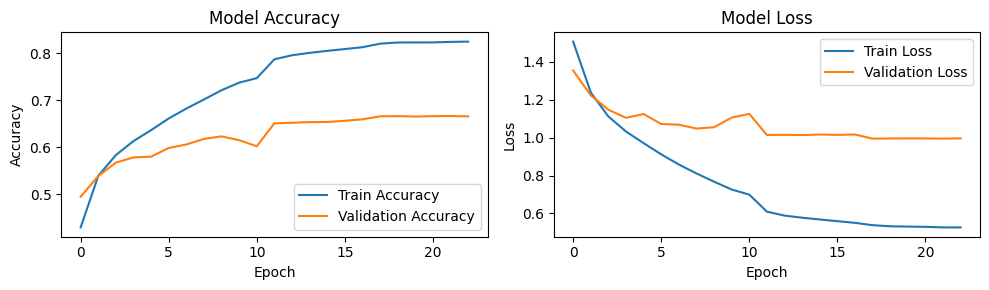

In [45]:
plot_history(history)

In [46]:
score = model.evaluate(val_generator, steps=len(X_val) // batch_size)
print('val loss:', score[0])
print('val accuracy:', score[1])

98/98 [==============================] - 106s 1s/step - loss: 0.9935 - accuracy: 0.6660
val loss: 0.9934861063957214
val accuracy: 0.6659709215164185


In [47]:
private_test_score = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print('test loss:', private_test_score[0])
print('test accuracy:', private_test_score[1])

98/98 [==============================] - 107s 1s/step - loss: 0.9727 - accuracy: 0.6715
test loss: 0.9726933836936951
test accuracy: 0.671476423740387


In [87]:
test_generator_for_predict = batch_generator(X_test, y_test, batch_size)

y_pred = model.predict(test_generator_for_predict, steps=len(X_test) // batch_size)
y_true = y_test[:len(y_pred)]

98/98 [==============================] - 105s 1s/step


In [97]:
do_classification_report(y_true, y_pred)

Precision: 0.6692
Recall: 0.6714
F1-score: 0.6700

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.61      0.60      1791
           1       0.97      1.00      0.99      1793
           2       0.58      0.54      0.56      1790
           3       0.68      0.65      0.66      1792
           4       0.50      0.48      0.49      1790
           5       0.80      0.82      0.81      1793
           6       0.56      0.59      0.57      1795

    accuracy                           0.67     12544
   macro avg       0.67      0.67      0.67     12544
weighted avg       0.67      0.67      0.67     12544



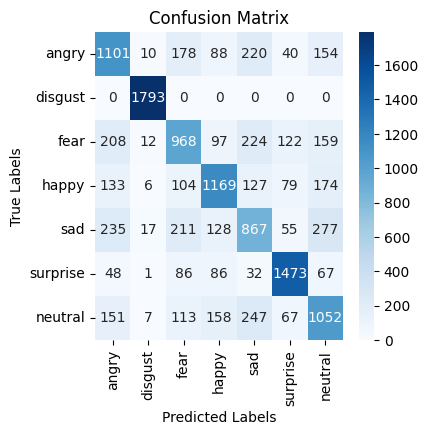

In [99]:
plot_confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), label_names)

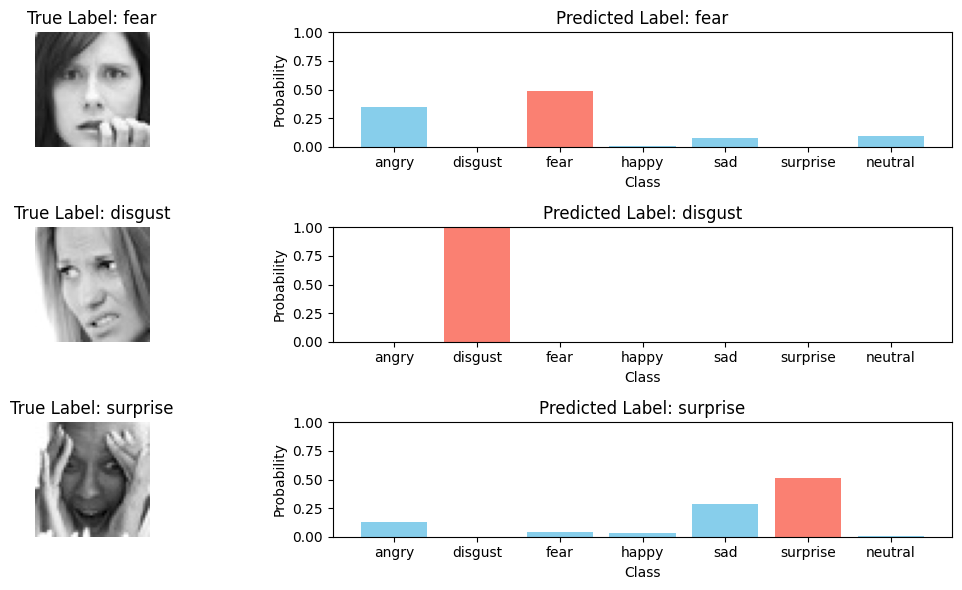

In [100]:
plot_correct_image_labels(X_test, y_true, y_pred, label_names, num_classes, image_shape)

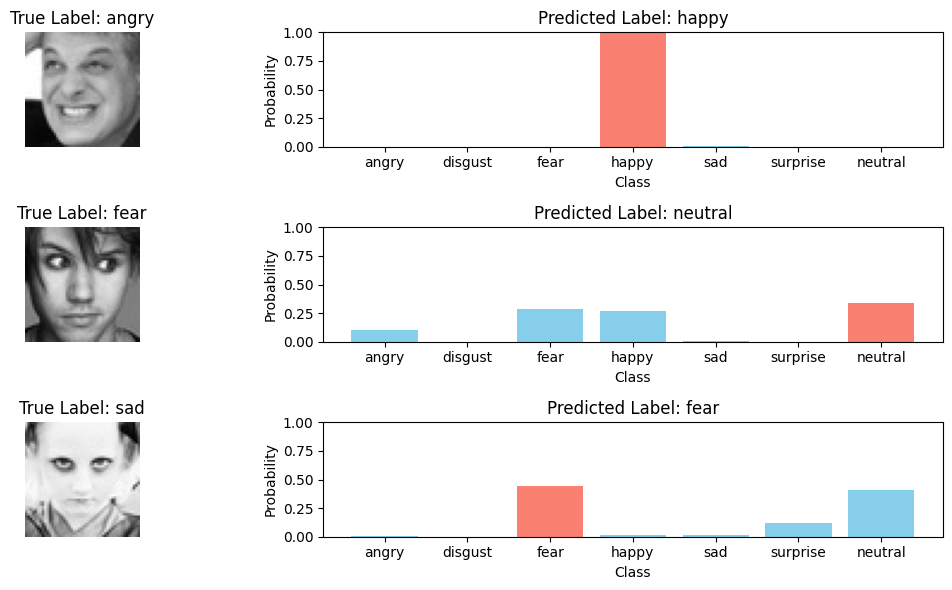

In [101]:
plot_wrong_image_labels(X_test, y_true, y_pred, label_names, num_classes, image_shape)

In [102]:
model.save('model_mobilenetv2.keras')